## Liquidity Analysis

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
sns.set_theme(style="whitegrid")

In [87]:
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")


In [84]:
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

df_liquidity_bad.columns

Index(['token_address', 'chain', 'token_name', 'price_usd', 'liquidity_usd',
       'market_cap_usd', 'liquidity_to_market_cap_ratio', 'token_volume',
       'volume_usd', 'volume_to_liquidity_ratio', 'locked_liquidity_percent',
       'locked_95_for_15_days', 'creator_under_5_percent',
       'creator_percent_of_lp', 'owner_under_5_percent', 'owner_percent_of_lp',
       'total_lp_supply', 'lp_holders_count', 'error'],
      dtype='object')

## Slippage analysis

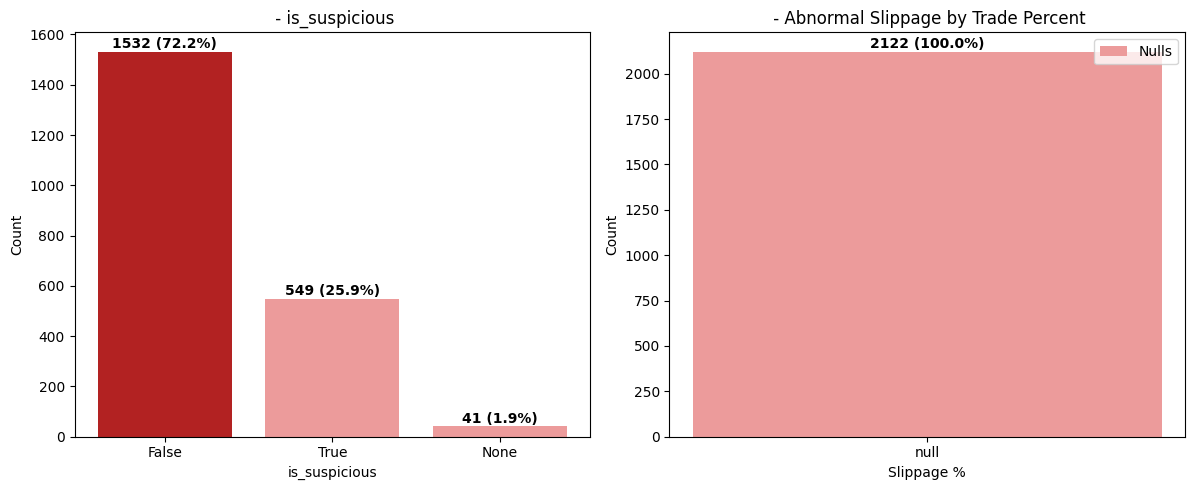

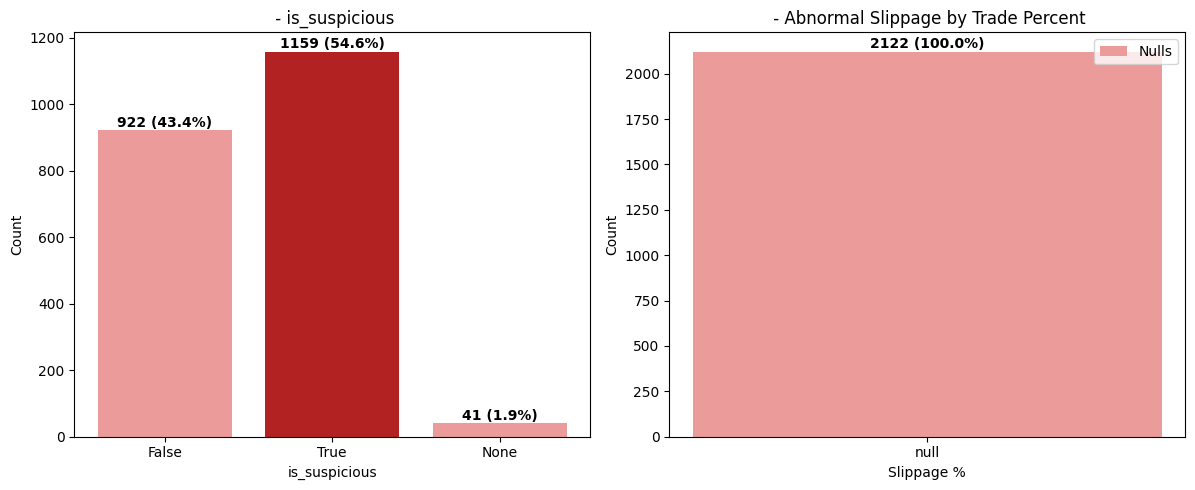

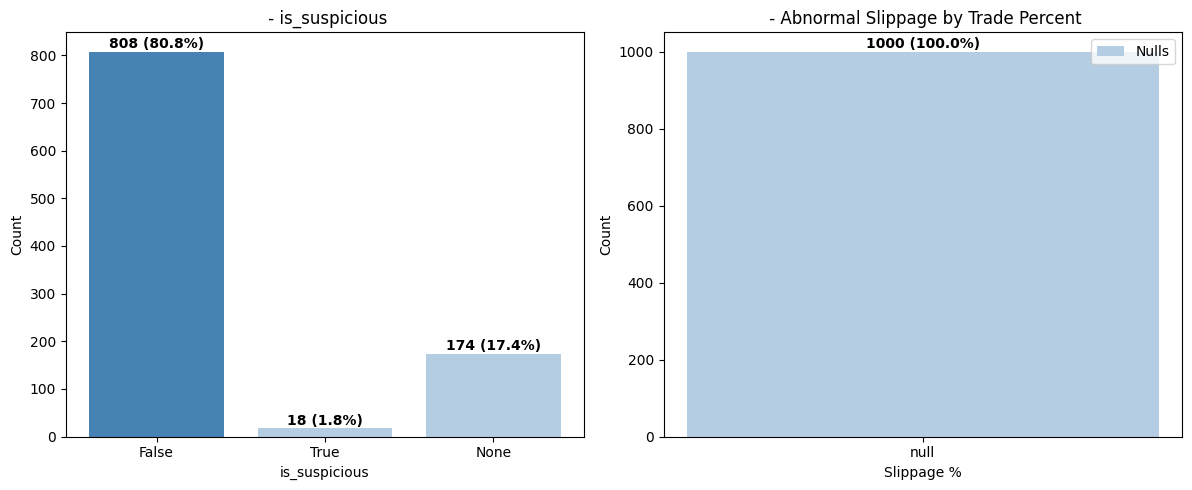

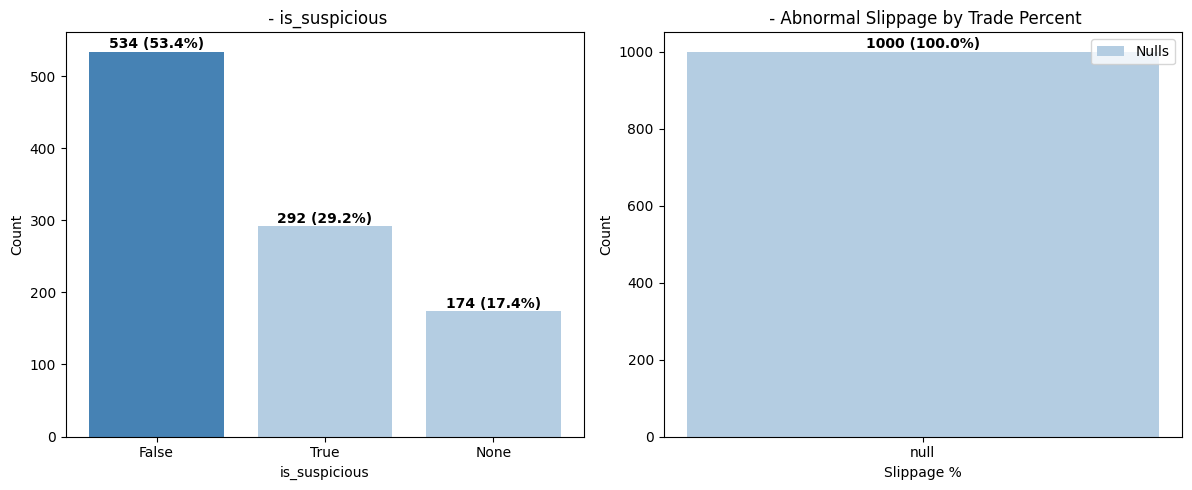

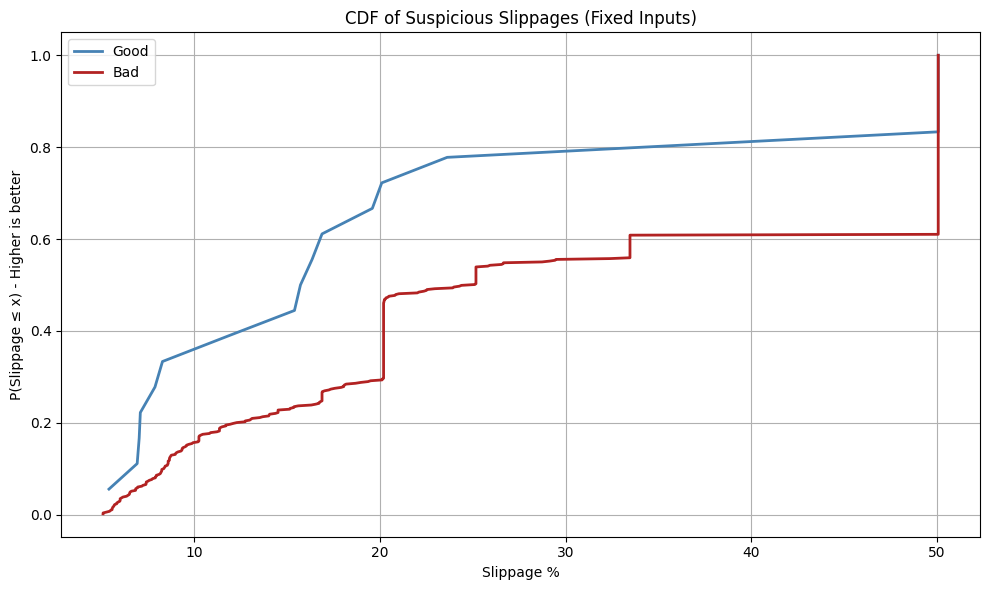

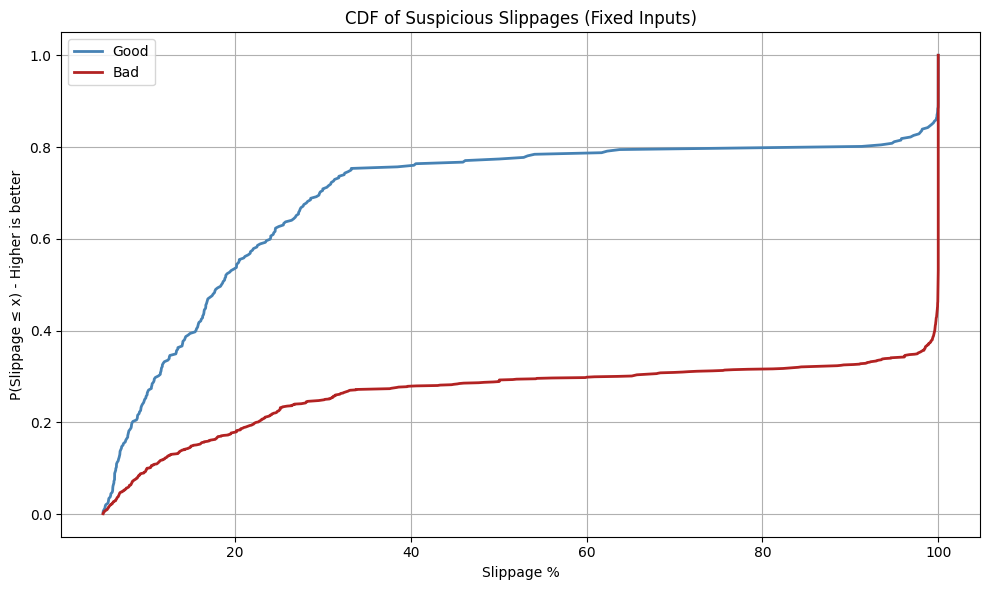

In [32]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_data_distribution(file_path, label=""):
    addresses = []
    is_suspicious_list = []
    percent_slippage_list = []
    fixed_slippage_list = []

    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        if line.endswith('": "eth"') or line.endswith('": "bsc"'):
            address = line.split('"')[0]
            addresses.append(address)

            i += 1
            if i >= len(lines):
                break

            next_line = lines[i].strip()
            if next_line == "null":
                is_suspicious_list.append(None)
                percent_slippage_list.append(None)
                fixed_slippage_list.append(None)
            else:
                json_lines = [next_line]
                brace_count = next_line.count('{') - next_line.count('}')
                while brace_count > 0 and i + 1 < len(lines):
                    i += 1
                    next_line = lines[i].strip()
                    json_lines.append(next_line)
                    brace_count += next_line.count('{') - next_line.count('}')

                try:
                    json_data = json.loads('\n'.join(json_lines))
                    is_suspicious_list.append(json_data.get("is_suspicious"))

                    percent_info = json_data.get("slippages_by_percent", {}).get("first_abnormal_slippage")
                    fixed_info = json_data.get("slippages_by_fixed_input", {}).get("first_abnormal_slippage")

                    percent_slippage_list.append(percent_info)
                    fixed_slippage_list.append(fixed_info)

                except Exception as e:
                    print(f"Error parsing JSON: {e}")
                    is_suspicious_list.append(None)
                    percent_slippage_list.append(None)
                    fixed_slippage_list.append(None)

        i += 1

    total = len(is_suspicious_list)

    # Decide primary color based on file type
    if "good" in file_path.lower():
        primary_color = "steelblue"
    elif "bad" in file_path.lower():
        primary_color = "firebrick"
    else:
        primary_color = "gray"

    lighter_color = lighten_color(primary_color, amount=0.4)

    # ---- Plot 1: Distribution of is_suspicious ----
    suspicious_counter = Counter(str(val) for val in is_suspicious_list)
    ordered_labels = ['False', 'True', 'None']
    counts = [suspicious_counter.get(label, 0) for label in ordered_labels]

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    max_count = max(counts) if counts else 1
    bar_colors = [primary_color if count == max_count else lighter_color for count in counts]
    bars1 = plt.bar(ordered_labels, counts, color=bar_colors)
    plt.title(f"{label} - is_suspicious")
    plt.xlabel("is_suspicious")
    plt.ylabel("Count")
    for bar, count in zip(bars1, counts):
        height = bar.get_height()
        pct = (count / total) * 100 if total else 0
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                f"{count} ({pct:.1f}%)",
                ha='center', va='bottom', fontweight='bold')

    # ---- Plot 2: Percent-based abnormal slippage ----
    plt.subplot(1, 3, 2)
    slippage_values_percent = [val["slippage_percent"]
                               for val in percent_slippage_list if val is not None]
    null_count_percent = percent_slippage_list.count(None)

    if slippage_values_percent:
        n, bins, patches = plt.hist(
            slippage_values_percent, bins=10, color=primary_color, alpha=0.7, label='Valid Slippages')

        for i in range(len(n)):
            count = int(n[i])
            pct = (count / len(slippage_values_percent)) * 100
            plt.text((bins[i] + bins[i+1]) / 2, n[i] + 0.5,
                     f"{count} ({pct:.1f}%)", ha='center', va='bottom', fontweight='bold')

    if null_count_percent > 0:
        bar = plt.bar('null', null_count_percent, color=lighter_color, label='Nulls')
        pct = (null_count_percent / total) * 100
        plt.text(bar[0].get_x() + bar[0].get_width()/2, null_count_percent + 0.5,
                 f"{null_count_percent} ({pct:.1f}%)", ha='center', va='bottom', fontweight='bold')

    plt.title(f"{label} - Abnormal Slippage by Trade Percent")
    plt.xlabel("Slippage %")
    plt.ylabel("Count")
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_data_distribution("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/BAD_slippage_log.txt")
plot_data_distribution("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/BAD2_slippage_log.txt")
plot_data_distribution("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/GOOD_slippage_log.txt")
plot_data_distribution("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/GOOD2_slippage_log.txt")


import json
import matplotlib.pyplot as plt
import numpy as np


def extract_suspicious_slippages(file_path):
    fixed_slippage_list = []
    is_suspicious_list = []

    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        if line.endswith('": "eth"') or line.endswith('": "bsc"'):
            i += 1
            if i >= len(lines):
                break

            next_line = lines[i].strip()
            if next_line != "null":
                json_lines = [next_line]
                brace_count = next_line.count('{') - next_line.count('}')
                while brace_count > 0 and i + 1 < len(lines):
                    i += 1
                    next_line = lines[i].strip()
                    json_lines.append(next_line)
                    brace_count += next_line.count('{') - next_line.count('}')

                try:
                    json_data = json.loads('\n'.join(json_lines))
                    is_suspicious_list.append(json_data.get("is_suspicious"))
                    fixed_info = json_data.get("slippages_by_fixed_input", {}).get("first_abnormal_slippage")
                    fixed_slippage_list.append(fixed_info)
                except Exception:
                    is_suspicious_list.append(None)
                    fixed_slippage_list.append(None)
            else:
                is_suspicious_list.append(None)
                fixed_slippage_list.append(None)
        i += 1

    suspicious_slippages = [
        val["slippage_percent"]
        for val, is_suspicious in zip(fixed_slippage_list, is_suspicious_list)
        if val is not None and is_suspicious is True
    ]

    return suspicious_slippages


def plot_combined_cdf(file1, file2, label1="Good", label2="Bad", color1="steelblue", color2="firebrick"):
    slippages_1 = extract_suspicious_slippages(file1)
    slippages_2 = extract_suspicious_slippages(file2)

    plt.figure(figsize=(10, 6))

    for slippages, label, color in [
        (slippages_1, label1, color1),
        (slippages_2, label2, color2)
    ]:
        if slippages:
            sorted_vals = np.sort(slippages)
            cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
            plt.plot(sorted_vals, cdf, label=label, linewidth=2, color=color)

    plt.title("CDF of Suspicious Slippages (Fixed Inputs)")
    plt.xlabel("Slippage %")
    plt.ylabel("P(Slippage ≤ x) - Higher is better")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_cdf("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/GOOD_slippage_log.txt","C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/BAD_slippage_log.txt")
plot_combined_cdf("C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/GOOD2_slippage_log.txt","C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/BAD2_slippage_log.txt")



## Locked and burned liquidity

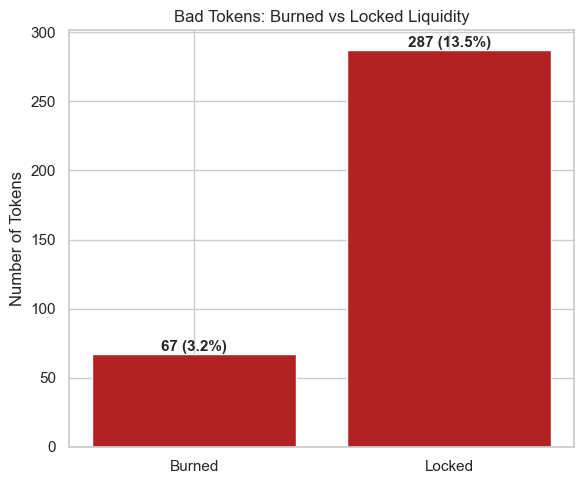

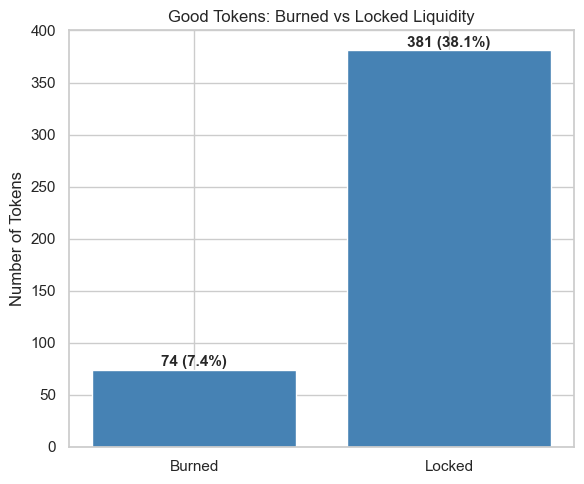

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

# Define burn addresses
burn_addresses = {
    "0x0000000000000000000000000000000000000000",
    "0x000000000000000000000000000000000000dEaD",
    "0x0000000000000000000000000000000000000001",
    "0x000000000000000000000000000000000000000d",
    "0x0000000000000000000000000000000000001000",
}

# Analyze LP holders
def analyze_lp_data(df_lp_holders):
    grouped = df_lp_holders.groupby("token_address")
    burned_tokens = set()
    locked_tokens = set()

    for token, group in grouped:
        token_has_locked = False
        token_has_burned = False

        for _, row in group.iterrows():
            addr = row["address"]
            balance = float(row["balance"])
            is_locked = row["is_locked"]

            if addr in burn_addresses and balance != 1e-15:
                token_has_burned = True
            if is_locked and not (addr == "0x0000000000000000000000000000000000000000" and balance == 1e-15):
                token_has_locked = True

        if token_has_burned:
            burned_tokens.add(token)
        if token_has_locked:
            locked_tokens.add(token)

    return {
        "burned_count": len(burned_tokens),
        "locked_count": len(locked_tokens),
        "total_tokens": len(grouped),
    }

# Run analysis
bad_result = analyze_lp_data(df_lp_holders_bad)
good_result = analyze_lp_data(df_lp_holders_good)

# Plot function
def plot_bar(result, title, color):
    labels = ["Burned", "Locked"]
    counts = [result["burned_count"], result["locked_count"]]
    total = result["total_tokens"]
    percents = [(count / total) * 100 for count in counts]

    fig, ax = plt.subplots(figsize=(6, 5))
    bars = ax.bar(labels, counts, color=color)
    ax.set_title(f"{title} Tokens: Burned vs Locked Liquidity")
    ax.set_ylabel("Number of Tokens")

    # Add count and percentage on top of bars
    for bar, count, percent in zip(bars, counts, percents):
        height = bar.get_height()
        label = f"{count} ({percent:.1f}%)"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            label,
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()


# Plot both graphs
plot_bar(bad_result, "Bad", "firebrick")
plot_bar(good_result, "Good", "steelblue")


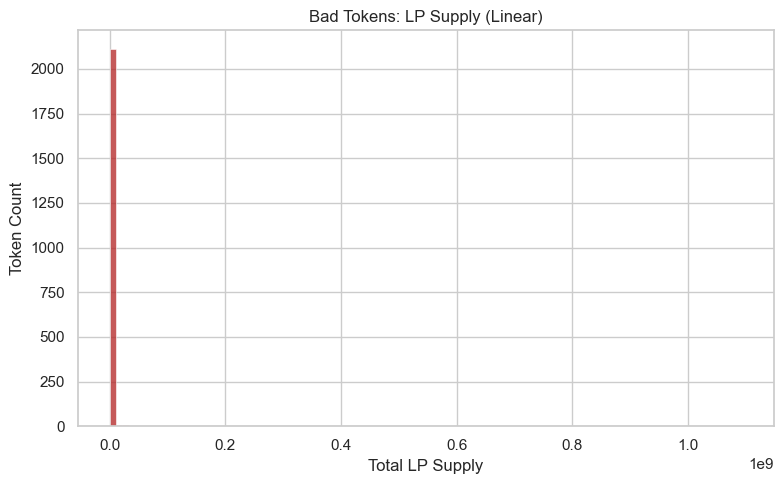

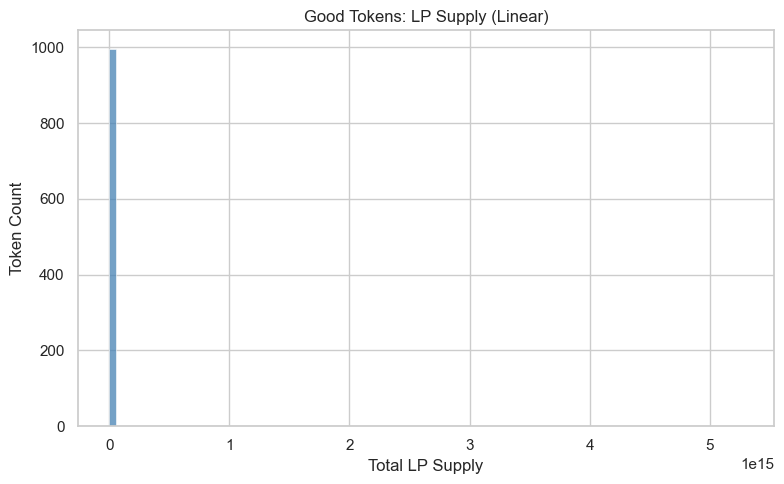

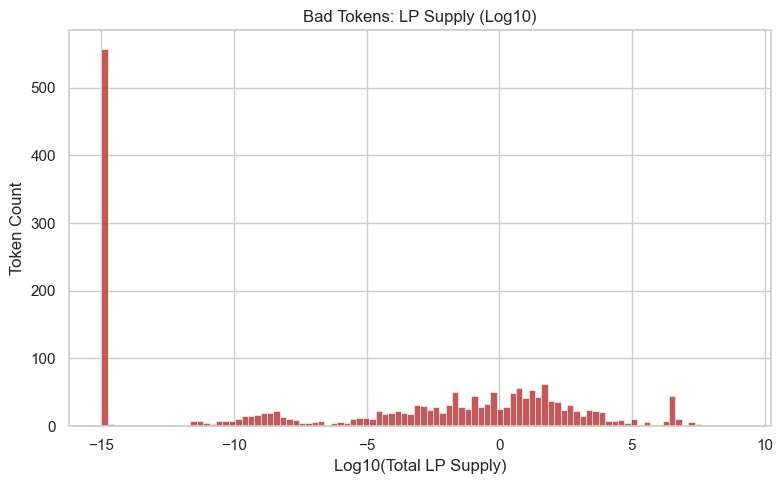

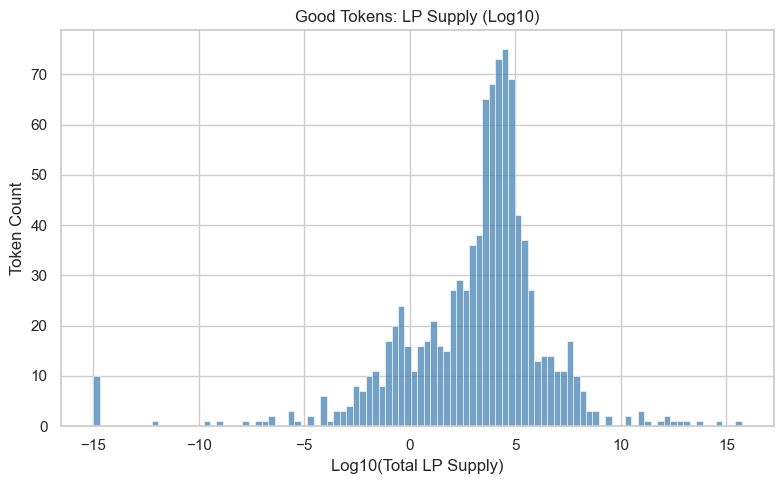

In [71]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean and convert LP supply values
def clean_lp_supply(df):
    df = df.copy()
    df = df[pd.to_numeric(df['total_lp_supply'], errors='coerce').notnull()]
    df['total_lp_supply'] = df['total_lp_supply'].astype(float)
    return df

df_bad_clean = clean_lp_supply(df_liquidity_bad)
df_good_clean = clean_lp_supply(df_liquidity_good)

# Prepare log values (avoid log(0) or negative)
log_lp_bad = np.log10(df_bad_clean[df_bad_clean['total_lp_supply'] > 0]['total_lp_supply'])
log_lp_good = np.log10(df_good_clean[df_good_clean['total_lp_supply'] > 0]['total_lp_supply'])

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# ==== 1. Bad Tokens - Linear Histogram ====
plt.figure(figsize=(8, 5))
sns.histplot(df_bad_clean['total_lp_supply'], bins=100, kde=False, color='firebrick')
plt.title("Bad Tokens: LP Supply (Linear)")
plt.xlabel("Total LP Supply")
plt.ylabel("Token Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 2. Good Tokens - Linear Histogram ====
plt.figure(figsize=(8, 5))
sns.histplot(df_good_clean['total_lp_supply'], bins=100, kde=False, color='steelblue')
plt.title("Good Tokens: LP Supply (Linear)")
plt.xlabel("Total LP Supply")
plt.ylabel("Token Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 3. Bad Tokens - Log10 Histogram ====
plt.figure(figsize=(8, 5))
sns.histplot(log_lp_bad, bins=100, kde=False, color='firebrick')
plt.title("Bad Tokens: LP Supply (Log10)")
plt.xlabel("Log10(Total LP Supply)")
plt.ylabel("Token Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 4. Good Tokens - Log10 Histogram ====
plt.figure(figsize=(8, 5))
sns.histplot(log_lp_good, bins=100, kde=False, color='steelblue')
plt.title("Good Tokens: LP Supply (Log10)")
plt.xlabel("Log10(Total LP Supply)")
plt.ylabel("Token Count")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_18528\1561361377.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad_log['log_lp'] = np.log10(df_bad_log['total_lp_supply'])
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_18528\1561361377.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good_log['log_lp'] = np.log10(df_good_log['total_lp_supply'])


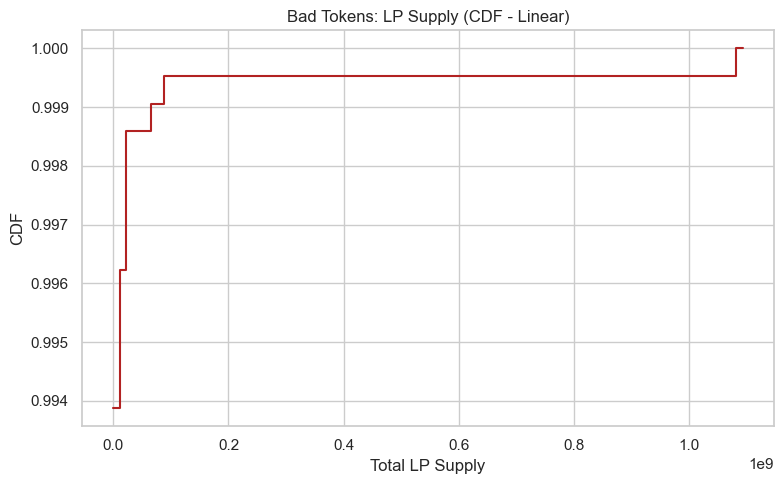

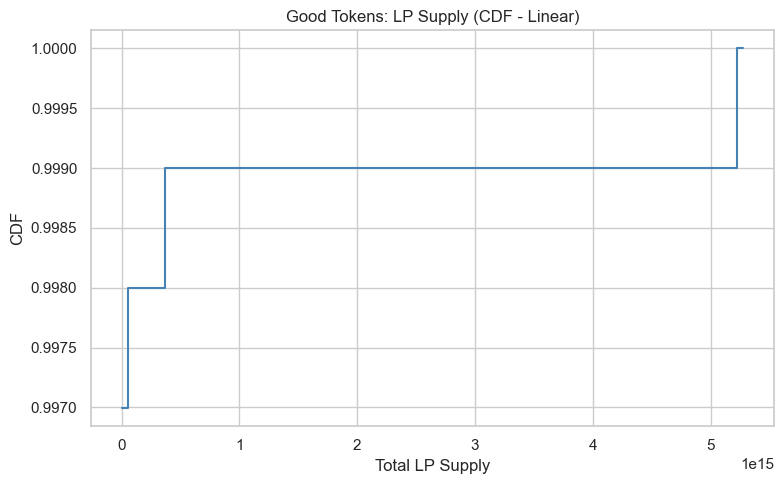

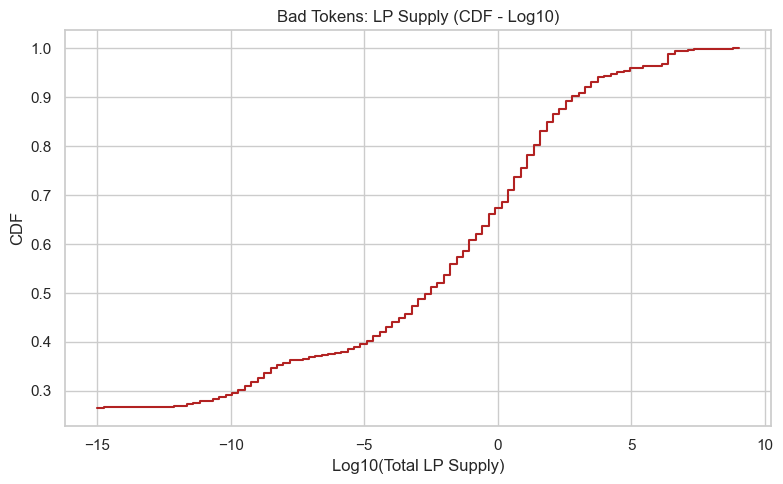

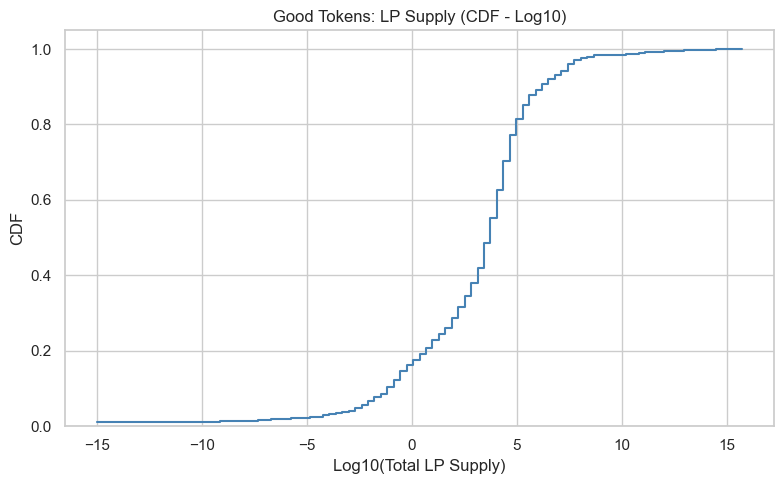

In [72]:
# ---- (same data loading & preprocessing as before) ----
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

def clean_lp_supply(df):
    df = df.copy()
    df = df[pd.to_numeric(df['total_lp_supply'], errors='coerce').notnull()]
    df['total_lp_supply'] = df['total_lp_supply'].astype(float)
    return df

df_bad_clean = clean_lp_supply(df_liquidity_bad)
df_good_clean = clean_lp_supply(df_liquidity_good)

df_bad_log = df_bad_clean[df_bad_clean['total_lp_supply'] > 0]
df_good_log = df_good_clean[df_good_clean['total_lp_supply'] > 0]
df_bad_log['log_lp'] = np.log10(df_bad_log['total_lp_supply'])
df_good_log['log_lp'] = np.log10(df_good_log['total_lp_supply'])

# ---- Seaborn theme ----
sns.set_theme(style="whitegrid")

# ==== 1. Bad Tokens - Linear CDF ====
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_bad_clean,
    x='total_lp_supply',
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='firebrick'
)
plt.title("Bad Tokens: LP Supply (CDF - Linear)")
plt.xlabel("Total LP Supply")
plt.ylabel("CDF")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 2. Good Tokens - Linear CDF ====
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_good_clean,
    x='total_lp_supply',
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='steelblue'
)
plt.title("Good Tokens: LP Supply (CDF - Linear)")
plt.xlabel("Total LP Supply")
plt.ylabel("CDF")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 3. Bad Tokens - Log10 CDF ====
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_bad_log,
    x='log_lp',
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='firebrick'
)
plt.title("Bad Tokens: LP Supply (CDF - Log10)")
plt.xlabel("Log10(Total LP Supply)")
plt.ylabel("CDF")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 4. Good Tokens - Log10 CDF ====
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_good_log,
    x='log_lp',
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='steelblue'
)
plt.title("Good Tokens: LP Supply (CDF - Log10)")
plt.xlabel("Log10(Total LP Supply)")
plt.ylabel("CDF")
plt.grid(True)
plt.tight_layout()
plt.show()


## Market cap distribution

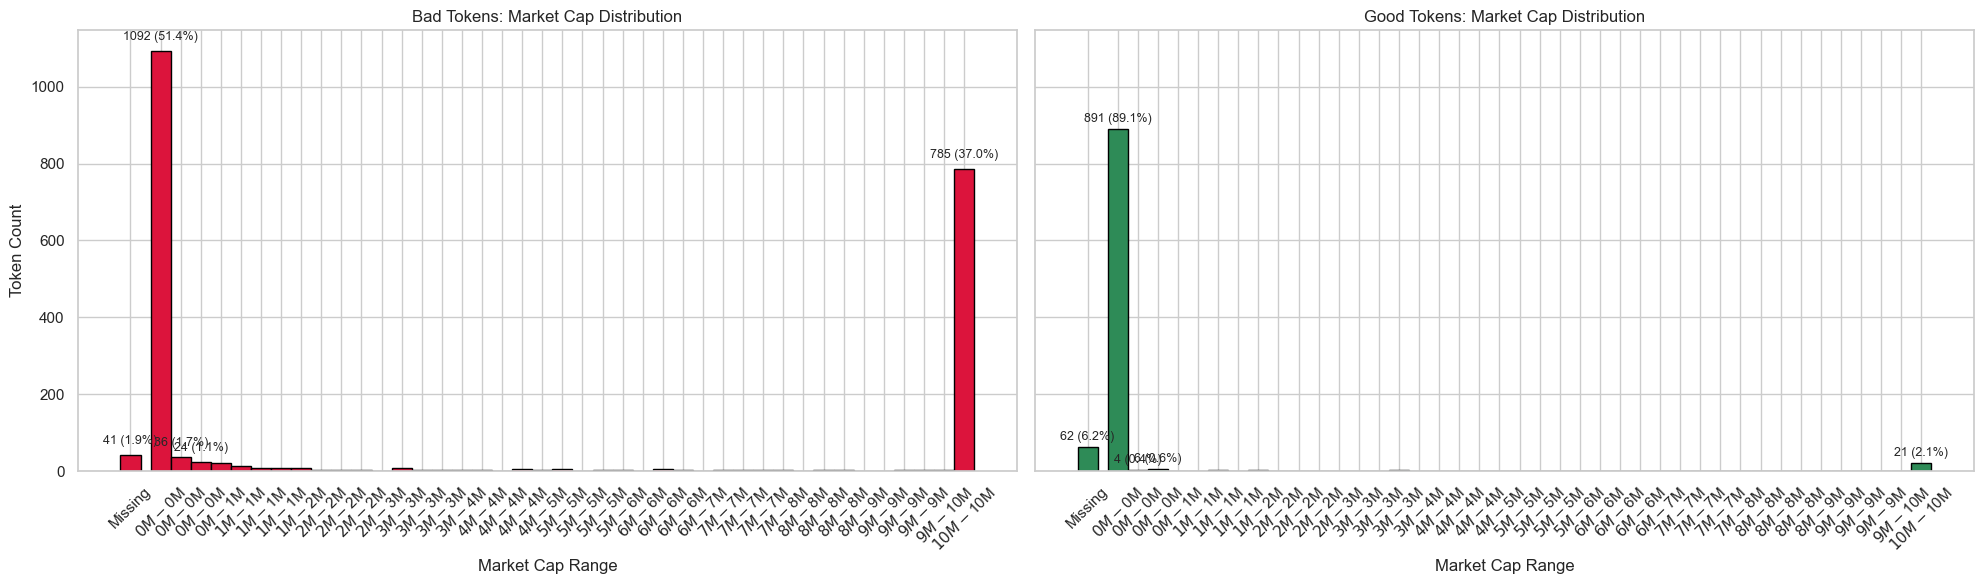

In [9]:
# Load data
df_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Shared bin settings
bin_edges = np.arange(0, 1.05e7, 2.5e5)  # $0 to $10M in $250K steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_centers_with_missing = np.insert(bin_centers, 0, -2.5e5)
labels = ['Missing'] + [f"${int(bin_edges[i]/1e6):,}M-${int(bin_edges[i+1]/1e6):,}M" for i in range(len(bin_edges)-1)]

def prepare_market_cap_distribution(df):
    df = df.copy()
    df['market_cap_usd_cleaned'] = pd.to_numeric(df['market_cap_usd'], errors='coerce')
    data = df['market_cap_usd_cleaned'].dropna()
    data_clipped = data.clip(upper=1e7)
    counts, _ = np.histogram(data_clipped, bins=bin_edges)
    counts = np.insert(counts, 0, df['market_cap_usd_cleaned'].isna().sum())  # Add missing
    return counts

# Get counts
counts_bad = prepare_market_cap_distribution(df_bad)
counts_good = prepare_market_cap_distribution(df_good)
total_bad = counts_bad.sum()
total_good = counts_good.sum()

# Identify top 5 bins for each
top_5_bad = np.argsort(counts_bad)[-5:]
top_5_good = np.argsort(counts_good)[-5:]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# --- BAD TOKENS ---
bars_bad = axes[0].bar(bin_centers_with_missing, counts_bad, width=2.5e5, color='crimson', edgecolor='black')
axes[0].set_title("Bad Tokens: Market Cap Distribution")
axes[0].set_xlabel("Market Cap Range")
axes[0].set_ylabel("Token Count")
axes[0].set_xticks(bin_centers_with_missing)
axes[0].set_xticklabels(labels, rotation=45)

# Annotate top 5
for i, bar in enumerate(bars_bad):
    if i in top_5_bad and counts_bad[i] > 0:
        pct = (counts_bad[i] / total_bad) * 100
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_bad * 0.01,
                     f'{counts_bad[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# --- GOOD TOKENS ---
bars_good = axes[1].bar(bin_centers_with_missing, counts_good, width=2.5e5, color='seagreen', edgecolor='black')
axes[1].set_title("Good Tokens: Market Cap Distribution")
axes[1].set_xlabel("Market Cap Range")
axes[1].set_xticks(bin_centers_with_missing)
axes[1].set_xticklabels(labels, rotation=45)

# Annotate top 5
for i, bar in enumerate(bars_good):
    if i in top_5_good and counts_good[i] > 0:
        pct = (counts_good[i] / total_good) * 100
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_good * 0.01,
                     f'{counts_good[i]} ({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Layout
plt.tight_layout()
plt.show()


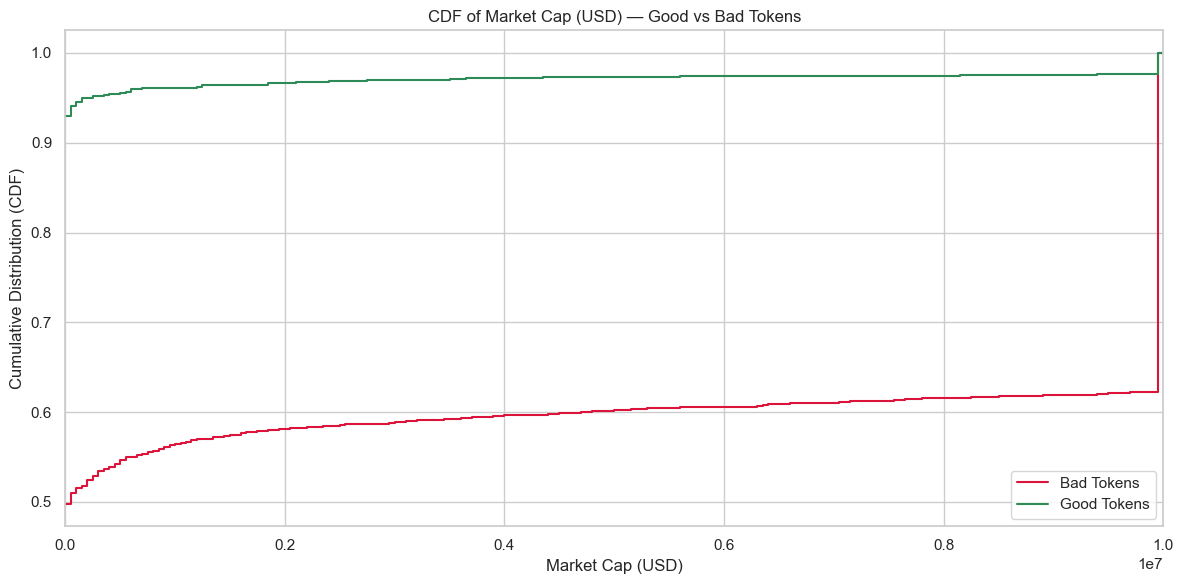

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean market cap data
def clean_market_cap(df):
    df = df.copy()
    df['market_cap_usd_cleaned'] = pd.to_numeric(df['market_cap_usd'], errors='coerce')
    return df['market_cap_usd_cleaned'].dropna().clip(upper=1e7)

market_cap_bad = clean_market_cap(df_bad)
market_cap_good = clean_market_cap(df_good)

# Set style
sns.set_theme(style='whitegrid')

# Plot
plt.figure(figsize=(12, 6))

# BAD tokens CDF
sns.histplot(
    market_cap_bad,
    stat='density',
    cumulative=True,
    bins=200,
    element='step',
    fill=False,
    color='crimson',
    label='Bad Tokens'
)

# GOOD tokens CDF
sns.histplot(
    market_cap_good,
    stat='density',
    cumulative=True,
    bins=200,
    element='step',
    fill=False,
    color='seagreen',
    label='Good Tokens'
)

# Labels and formatting
plt.title("CDF of Market Cap (USD) — Good vs Bad Tokens")
plt.xlabel("Market Cap (USD)")
plt.ylabel("Cumulative Distribution (CDF)")
plt.xlim(0, 1e7)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Market cap and liquidity pool depth

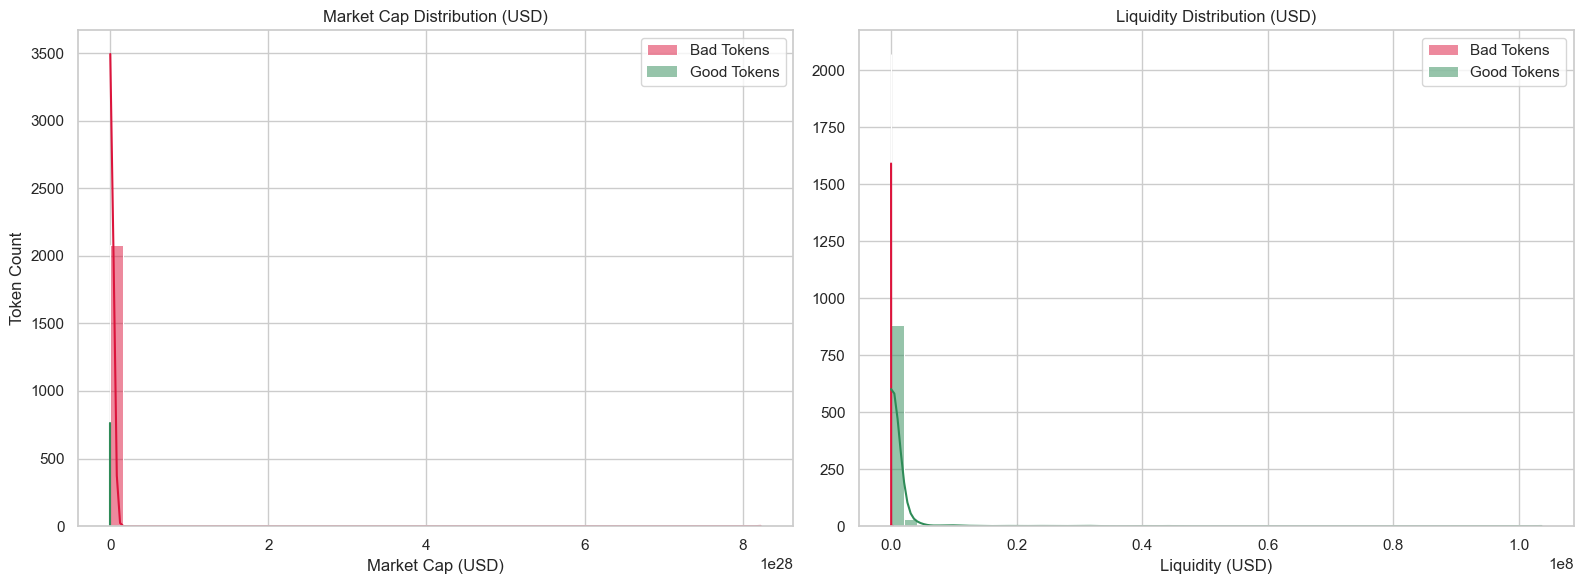

In [11]:
# Load the correct data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean and convert numeric columns
for df in [df_liquidity_bad, df_liquidity_good]:
    df['market_cap_usd'] = pd.to_numeric(df['market_cap_usd'], errors='coerce')
    df['liquidity_usd'] = pd.to_numeric(df['liquidity_usd'], errors='coerce')

# Set theme
sns.set_theme(style="whitegrid")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Market Cap plot
sns.histplot(df_liquidity_bad['market_cap_usd'].dropna(), bins=50, color='crimson', label='Bad Tokens', ax=axes[0], kde=True)
sns.histplot(df_liquidity_good['market_cap_usd'].dropna(), bins=50, color='seagreen', label='Good Tokens', ax=axes[0], kde=True)
axes[0].set_title('Market Cap Distribution (USD)')
axes[0].set_xlabel('Market Cap (USD)')
axes[0].set_ylabel('Token Count')
axes[0].legend()

# Liquidity plot
sns.histplot(df_liquidity_bad['liquidity_usd'].dropna(), bins=50, color='crimson', label='Bad Tokens', ax=axes[1], kde=True)
sns.histplot(df_liquidity_good['liquidity_usd'].dropna(), bins=50, color='seagreen', label='Good Tokens', ax=axes[1], kde=True)
axes[1].set_title('Liquidity Distribution (USD)')
axes[1].set_xlabel('Liquidity (USD)')
axes[1].set_ylabel('')
axes[1].legend()

# Final layout
plt.tight_layout()
plt.show()


## Volume to liquidity ratio

In [89]:
df_liquidity_bad.volume_to_liquidity_ratio.sum


<bound method Series.sum of 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2118    0.0
2119    0.0
2120    0.0
2121    0.0
2122    0.0
Name: volume_to_liquidity_ratio, Length: 2123, dtype: float64>

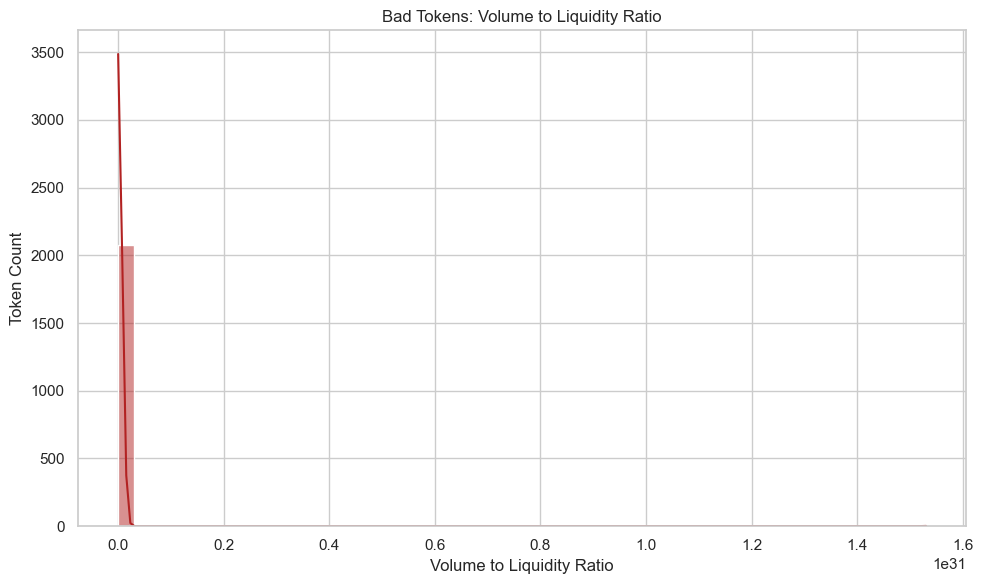

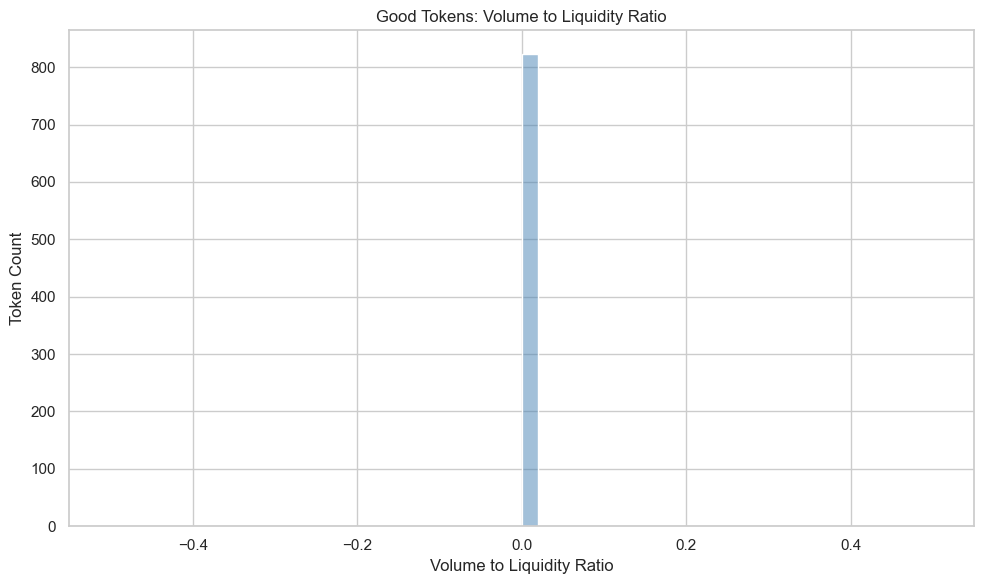

In [78]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Convert column to numeric
for df in [df_liquidity_bad, df_liquidity_good]:
    df['volume_to_liquidity_ratio'] = pd.to_numeric(df['volume_to_liquidity_ratio'], errors='coerce')

# Set seaborn theme
sns.set_theme(style="whitegrid")

# ==== Plot for BAD tokens ====
plt.figure(figsize=(10, 6))
sns.histplot(
    df_liquidity_bad['volume_to_liquidity_ratio'].dropna(),
    bins=50,
    kde=True,
    color='firebrick'
)
plt.title('Bad Tokens: Volume to Liquidity Ratio')
plt.xlabel('Volume to Liquidity Ratio')
plt.ylabel('Token Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot for GOOD tokens ====
plt.figure(figsize=(10, 6))
sns.histplot(
    df_liquidity_good['volume_to_liquidity_ratio'].dropna(),
    bins=50,
    kde=True,
    color='steelblue'
)
plt.title('Good Tokens: Volume to Liquidity Ratio')
plt.xlabel('Volume to Liquidity Ratio')
plt.ylabel('Token Count')
plt.grid(True)
plt.tight_layout()
plt.show()


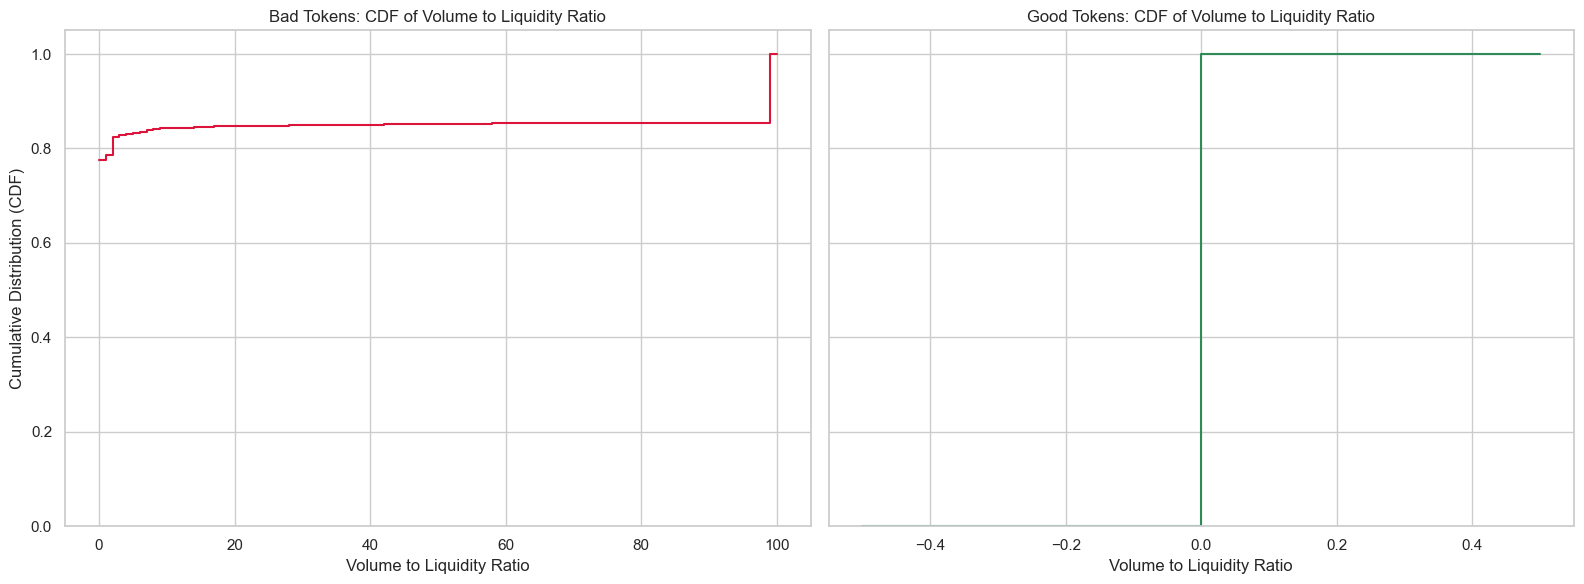

In [13]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Convert to numeric (handle possible strings or NaNs)
for df in [df_liquidity_bad, df_liquidity_good]:
    df['volume_to_liquidity_ratio'] = pd.to_numeric(df['volume_to_liquidity_ratio'], errors='coerce')

# Drop NaNs for plotting
v2l_bad = df_liquidity_bad['volume_to_liquidity_ratio'].dropna()
v2l_good = df_liquidity_good['volume_to_liquidity_ratio'].dropna()

# Optional: Clip extreme outliers for better visualization
v2l_bad = v2l_bad.clip(upper=100)
v2l_good = v2l_good.clip(upper=100)

# Set theme
sns.set_theme(style="whitegrid")

# Set up side-by-side CDF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- BAD tokens ---
sns.histplot(
    v2l_bad,
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='crimson',
    ax=axes[0]
)
axes[0].set_title('Bad Tokens: CDF of Volume to Liquidity Ratio')
axes[0].set_xlabel('Volume to Liquidity Ratio')
axes[0].set_ylabel('Cumulative Distribution (CDF)')
axes[0].grid(True)

# --- GOOD tokens ---
sns.histplot(
    v2l_good,
    bins=100,
    stat='density',
    cumulative=True,
    element='step',
    fill=False,
    color='seagreen',
    ax=axes[1]
)
axes[1].set_title('Good Tokens: CDF of Volume to Liquidity Ratio')
axes[1].set_xlabel('Volume to Liquidity Ratio')
axes[1].set_ylabel('')
axes[1].grid(True)

# Layout
plt.tight_layout()
plt.show()


## At least 95% of largest pool's liquidity token burned/locked for 15 days or longer

In [42]:
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

df_liquidity_bad['locked_95_for_15_days'].astype(str).str.strip().str.lower().isin(['false', '0', 'yes']).sum()


np.int64(2123)

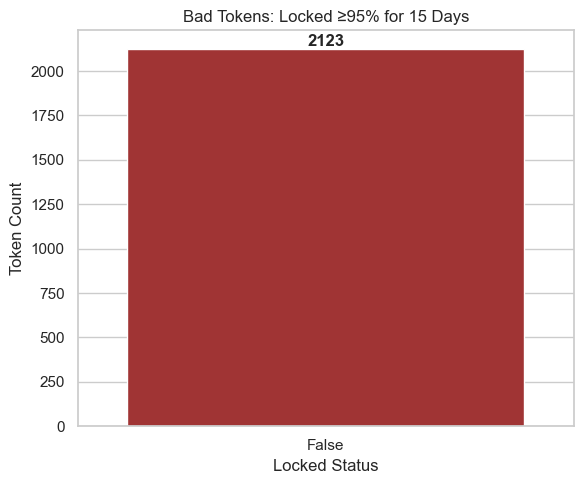

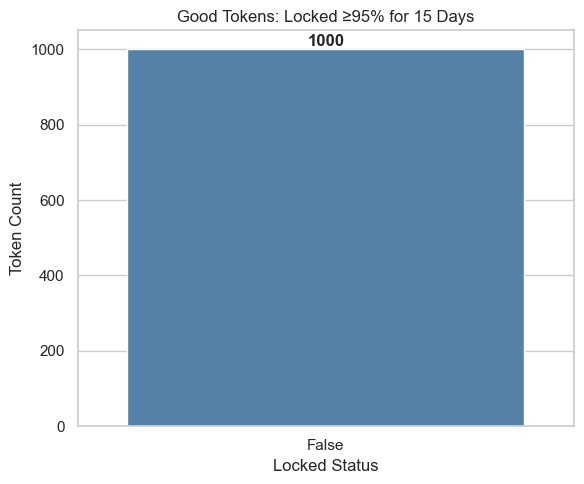

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to robustly clean and coerce to boolean
def clean_locked_column(df):
    df = df.copy()
    
    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return False  # Coerce None or invalid to False

    df['locked_clean'] = df['locked_95_for_15_days'].apply(to_bool)
    return df

# Clean both datasets
df_bad_clean = clean_locked_column(df_liquidity_bad)
df_good_clean = clean_locked_column(df_liquidity_good)

# Count values
locked_counts_bad = df_bad_clean['locked_clean'].value_counts().sort_index()
locked_counts_good = df_good_clean['locked_clean'].value_counts().sort_index()

# --- Plot BAD tokens ---
plt.figure(figsize=(6, 5))
sns.set_theme(style="whitegrid")
bars_bad = sns.barplot(
    x=locked_counts_bad.index.astype(str),
    y=locked_counts_bad.values,
    color='firebrick'
)
plt.title('Bad Tokens: Locked ≥95% for 15 Days')
plt.xlabel('Locked Status')
plt.ylabel('Token Count')

# Annotate bars
for bar, count in zip(bars_bad.patches, locked_counts_bad.values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{count}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# --- Plot GOOD tokens ---
plt.figure(figsize=(6, 5))
bars_good = sns.barplot(
    x=locked_counts_good.index.astype(str),
    y=locked_counts_good.values,
    color='steelblue'
)
plt.title('Good Tokens: Locked ≥95% for 15 Days')
plt.xlabel('Locked Status')
plt.ylabel('Token Count')

# Annotate bars
for bar, count in zip(bars_good.patches, locked_counts_good.values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{count}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


## Owner/creator wallet contains less than 5% of liquidity

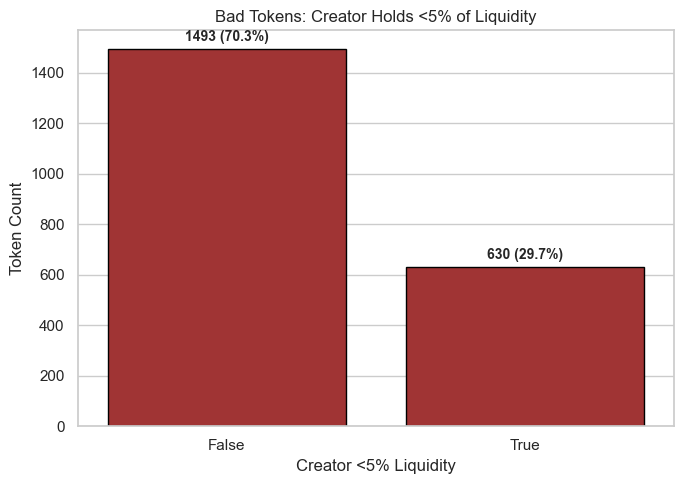

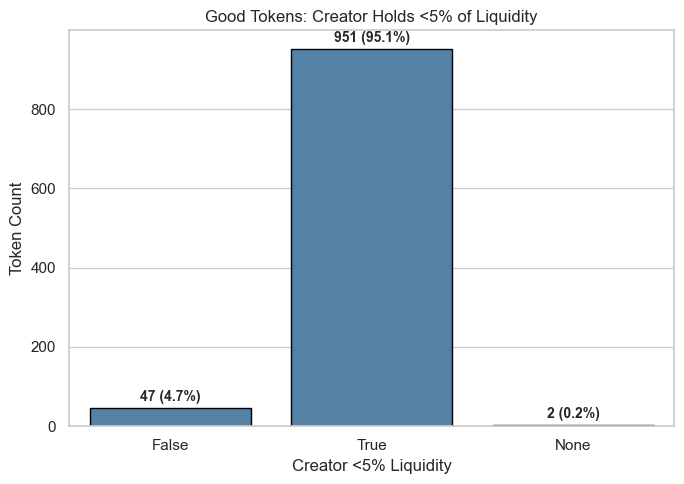

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to robustly clean 'creator_under_5_percent' column
def clean_creator_hold_column(df):
    df = df.copy()

    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return None

    df['creator_under_5_clean'] = df['creator_under_5_percent'].apply(to_bool)
    return df

# Apply cleaning
df_bad_clean = clean_creator_hold_column(df_liquidity_bad)
df_good_clean = clean_creator_hold_column(df_liquidity_good)

# Count values
creator_counts_bad = df_bad_clean['creator_under_5_clean'].value_counts(dropna=False).sort_index()
creator_counts_good = df_good_clean['creator_under_5_clean'].value_counts(dropna=False).sort_index()

# Compute totals
total_bad = creator_counts_bad.sum()
total_good = creator_counts_good.sum()

sns.set_theme(style="whitegrid")

# ============================
# 🔴 Figure 1 — Bad Tokens
# ============================
fig1, ax1 = plt.subplots(figsize=(7, 5))

sns.barplot(x=creator_counts_bad.index.astype(str), 
            y=creator_counts_bad.values, 
            color='firebrick', 
            edgecolor='black',
            ax=ax1)

ax1.set_title('Bad Tokens: Creator Holds <5% of Liquidity')
ax1.set_xlabel('Creator <5% Liquidity')
ax1.set_ylabel('Token Count')

# Add bold annotations
for i, (val, count) in enumerate(creator_counts_bad.items()):
    pct = (count / total_bad) * 100
    ax1.text(i, count + total_bad * 0.01, 
             f'{count} ({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


# ============================
# 🔵 Figure 2 — Good Tokens
# ============================
fig2, ax2 = plt.subplots(figsize=(7, 5))

sns.barplot(x=creator_counts_good.index.astype(str), 
            y=creator_counts_good.values, 
            color='steelblue', 
            edgecolor='black',
            ax=ax2)

ax2.set_title('Good Tokens: Creator Holds <5% of Liquidity')
ax2.set_xlabel('Creator <5% Liquidity')
ax2.set_ylabel('Token Count')

# Add bold annotations
for i, (val, count) in enumerate(creator_counts_good.items()):
    pct = (count / total_good) * 100
    ax2.text(i, count + total_good * 0.01, 
             f'{count} ({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


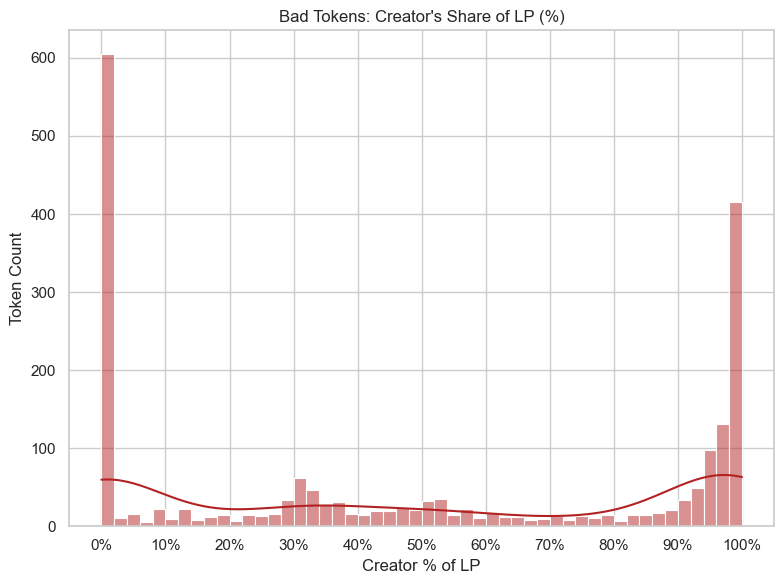

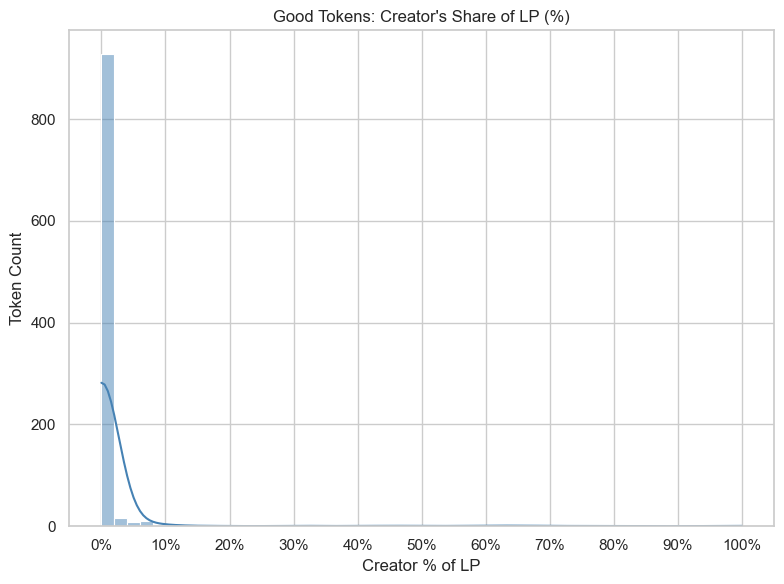

In [52]:
# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to clean and clip creator percent of LP
def clean_creator_lp_percent(df):
    df = df.copy()
    df['creator_percent_of_lp_cleaned'] = pd.to_numeric(df['creator_percent_of_lp'], errors='coerce').clip(0, 100)
    return df

# Apply cleaning
df_bad_clean = clean_creator_lp_percent(df_liquidity_bad)
df_good_clean = clean_creator_lp_percent(df_liquidity_good)

# Set seaborn style
sns.set_theme(style="whitegrid")

# ================================
# 🔴 Figure 1 — Bad Tokens
# ================================
fig1, ax1 = plt.subplots(figsize=(8, 6))

sns.histplot(df_bad_clean['creator_percent_of_lp_cleaned'].dropna(), 
             bins=50, kde=True, color='firebrick', ax=ax1)

ax1.set_title("Bad Tokens: Creator's Share of LP (%)")
ax1.set_xlabel("Creator % of LP")
ax1.set_ylabel("Token Count")
ax1.set_xticks(range(0, 110, 10))
ax1.set_xticklabels([f"{x}%" for x in range(0, 110, 10)])

plt.tight_layout()
plt.show()

# ================================
# 🔵 Figure 2 — Good Tokens
# ================================
fig2, ax2 = plt.subplots(figsize=(8, 6))

sns.histplot(df_good_clean['creator_percent_of_lp_cleaned'].dropna(), 
             bins=50, kde=True, color='steelblue', ax=ax2)

ax2.set_title("Good Tokens: Creator's Share of LP (%)")
ax2.set_xlabel("Creator % of LP")
ax2.set_ylabel("Token Count")
ax2.set_xticks(range(0, 110, 10))
ax2.set_xticklabels([f"{x}%" for x in range(0, 110, 10)])

plt.tight_layout()
plt.show()


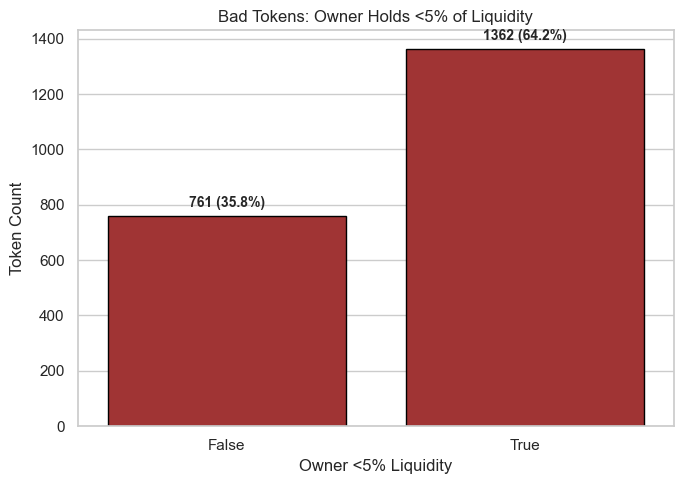

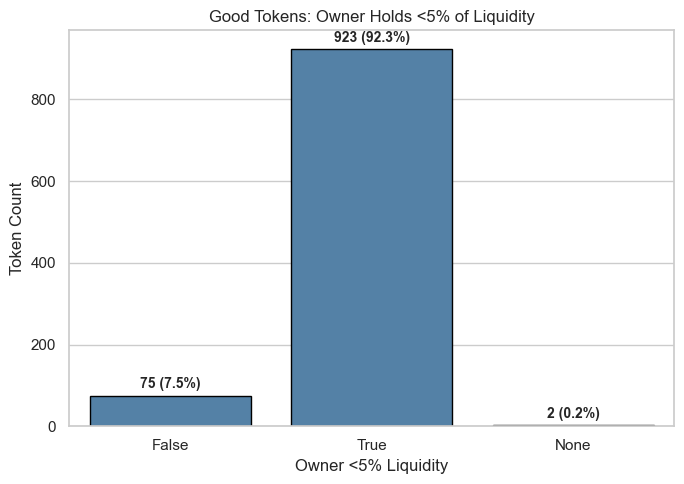

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Function to clean and convert the column to boolean
def clean_owner_under_5_column(df):
    df = df.copy()

    def to_bool(val):
        val = str(val).strip().lower()
        if val in ['true', '1', 'yes']:
            return True
        elif val in ['false', '0', 'no']:
            return False
        else:
            return None

    df['owner_under_5_cleaned'] = df['owner_under_5_percent'].apply(to_bool)
    return df

# Clean both datasets
df_bad_clean = clean_owner_under_5_column(df_liquidity_bad)
df_good_clean = clean_owner_under_5_column(df_liquidity_good)

# Count values
owner_counts_bad = df_bad_clean['owner_under_5_cleaned'].value_counts(dropna=False).sort_index()
owner_counts_good = df_good_clean['owner_under_5_cleaned'].value_counts(dropna=False).sort_index()

# Totals
total_bad = owner_counts_bad.sum()
total_good = owner_counts_good.sum()

sns.set_theme(style="whitegrid")

# =============================
# 🔴 Figure 1 — Bad Tokens
# =============================
fig1, ax1 = plt.subplots(figsize=(7, 5))

sns.barplot(x=owner_counts_bad.index.astype(str), y=owner_counts_bad.values,
            color='firebrick', edgecolor='black', ax=ax1)

ax1.set_title('Bad Tokens: Owner Holds <5% of Liquidity')
ax1.set_xlabel('Owner <5% Liquidity')
ax1.set_ylabel('Token Count')

# Add bold annotations
for i, (val, count) in enumerate(owner_counts_bad.items()):
    pct = (count / total_bad) * 100
    ax1.text(i, count + total_bad * 0.01, 
             f"{count} ({pct:.1f}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# =============================
# 🔵 Figure 2 — Good Tokens
# =============================
fig2, ax2 = plt.subplots(figsize=(7, 5))

sns.barplot(x=owner_counts_good.index.astype(str), y=owner_counts_good.values,
            color='steelblue', edgecolor='black', ax=ax2)

ax2.set_title('Good Tokens: Owner Holds <5% of Liquidity')
ax2.set_xlabel('Owner <5% Liquidity')
ax2.set_ylabel('Token Count')

# Add bold annotations
for i, (val, count) in enumerate(owner_counts_good.items()):
    pct = (count / total_good) * 100
    ax2.text(i, count + total_good * 0.01, 
             f"{count} ({pct:.1f}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


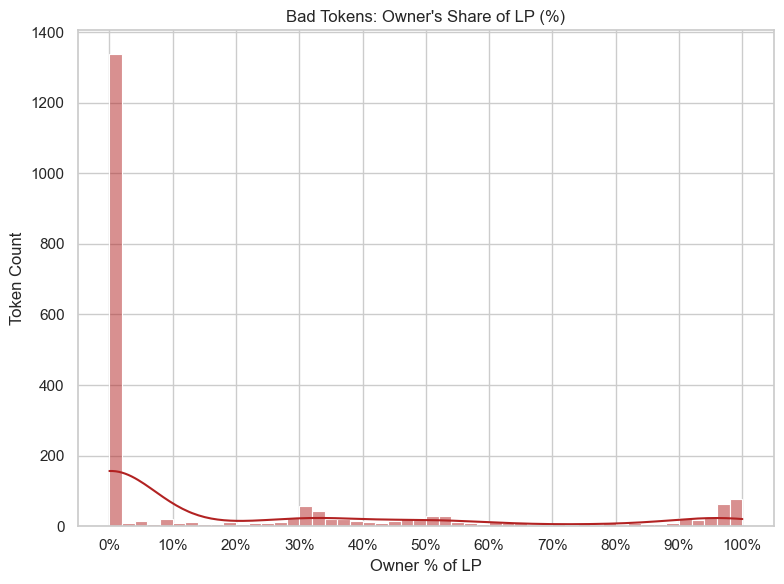

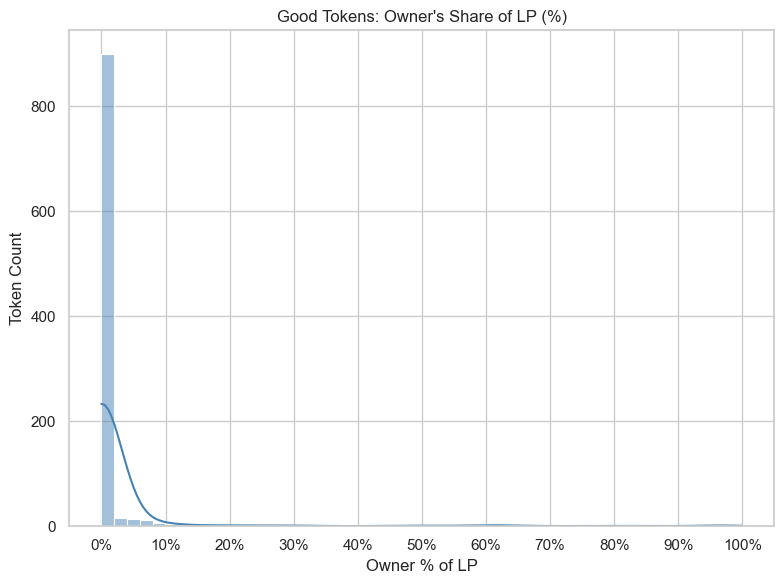

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

# Clean and clip owner_percent_of_lp
def clean_owner_lp_percent(df):
    df = df.copy()
    df['owner_percent_of_lp_cleaned'] = pd.to_numeric(df['owner_percent_of_lp'], errors='coerce').clip(0, 100)
    return df

# Apply cleaning
df_bad_clean = clean_owner_lp_percent(df_liquidity_bad)
df_good_clean = clean_owner_lp_percent(df_liquidity_good)

# Set seaborn style
sns.set_theme(style="whitegrid")

# ================================
# 🔴 Figure 1 — Bad Tokens
# ================================
fig1, ax1 = plt.subplots(figsize=(8, 6))

sns.histplot(df_bad_clean['owner_percent_of_lp_cleaned'].dropna(), 
             bins=50, kde=True, color='firebrick', ax=ax1)

ax1.set_title("Bad Tokens: Owner's Share of LP (%)")
ax1.set_xlabel("Owner % of LP")
ax1.set_ylabel("Token Count")
ax1.set_xticks(range(0, 110, 10))
ax1.set_xticklabels([f"{x}%" for x in range(0, 110, 10)])

plt.tight_layout()
plt.show()

# ================================
# 🔵 Figure 2 — Good Tokens
# ================================
fig2, ax2 = plt.subplots(figsize=(8, 6))

sns.histplot(df_good_clean['owner_percent_of_lp_cleaned'].dropna(), 
             bins=50, kde=True, color='steelblue', ax=ax2)

ax2.set_title("Good Tokens: Owner's Share of LP (%)")
ax2.set_xlabel("Owner % of LP")
ax2.set_ylabel("Token Count")
ax2.set_xticks(range(0, 110, 10))
ax2.set_xticklabels([f"{x}%" for x in range(0, 110, 10)])

plt.tight_layout()
plt.show()


## Locked liquidity % distribution

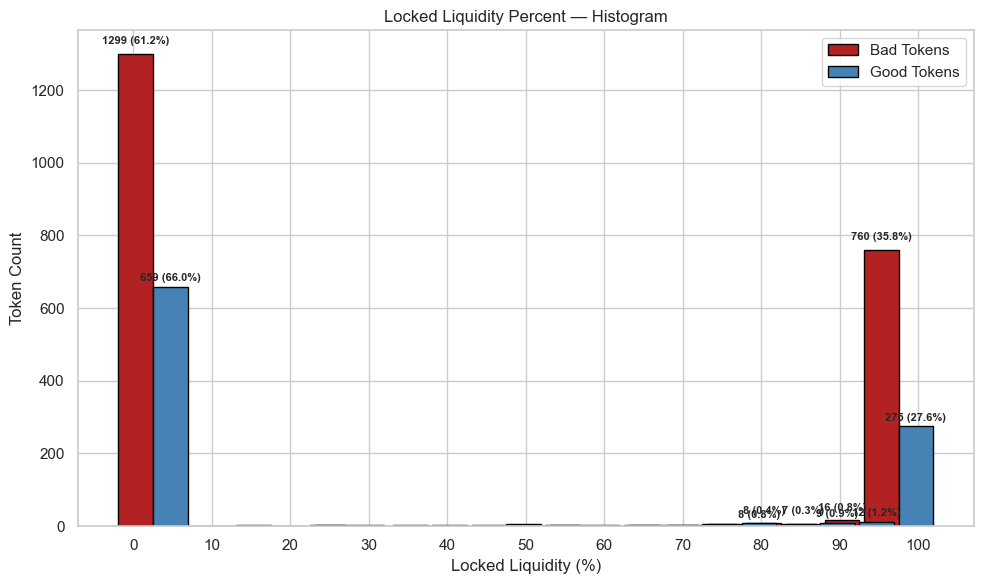

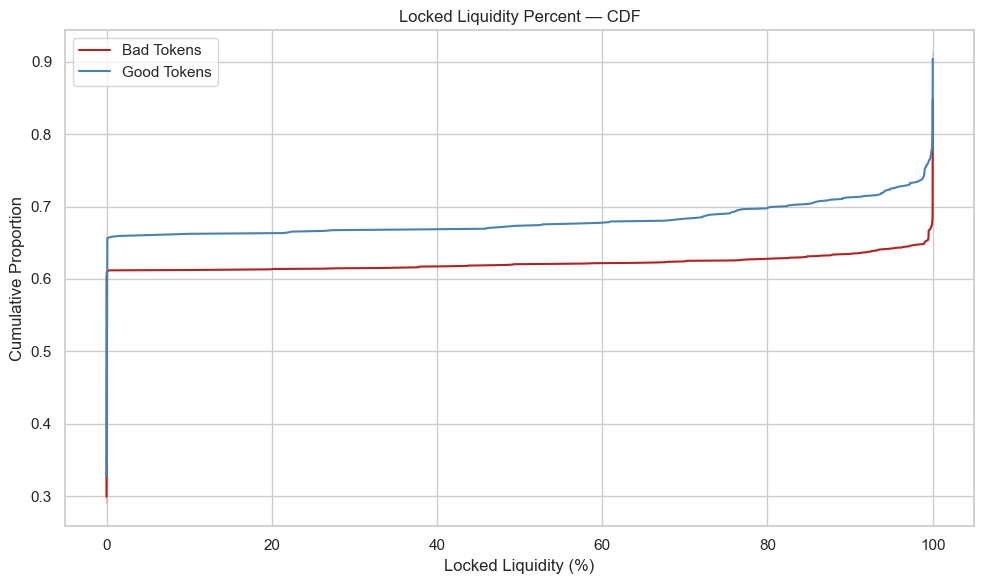

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df_liquidity_bad = pd.read_csv("../csv_outputs/bad_tokens/master_liquidity.csv")
df_liquidity_good = pd.read_csv("../csv_outputs/good_tokens/master_liquidity.csv")

def prepare_locked_liquidity_hist(df, col='locked_liquidity_percent'):
    cleaned = pd.to_numeric(df[col], errors='coerce').clip(0, 100).dropna()
    bin_edges = np.linspace(0, 100, 21)  # 20 bins of 5%
    counts, _ = np.histogram(cleaned, bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    total = counts.sum()
    top_indices = np.argsort(counts)[-5:]  # Top 5 bins by count
    return bin_centers, counts, total, cleaned, top_indices

def compute_cdf(data):
    sorted_vals = np.sort(data)
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    return sorted_vals, cdf

# Prepare data
centers_bad, counts_bad, total_bad, cleaned_bad, top_bad = prepare_locked_liquidity_hist(df_liquidity_bad)
centers_good, counts_good, total_good, cleaned_good, top_good = prepare_locked_liquidity_hist(df_liquidity_good)
x_cdf_bad, y_cdf_bad = compute_cdf(cleaned_bad)
x_cdf_good, y_cdf_good = compute_cdf(cleaned_good)

# =============================================
# Plot 1: Histogram (Locked Liquidity Percent)
# =============================================
fig1, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 2.2
offset = bar_width

# Histogram bars
ax1.bar(centers_bad - offset, counts_bad, width=bar_width*2,
        label='Bad Tokens', color='firebrick', edgecolor='black')

ax1.bar(centers_good + offset, counts_good, width=bar_width*2,
        label='Good Tokens', color='steelblue', edgecolor='black')

# Title and labels
ax1.set_title('Locked Liquidity Percent — Histogram')
ax1.set_xlabel('Locked Liquidity (%)')
ax1.set_ylabel('Token Count')
ax1.set_xticks(np.arange(0, 110, 10))
ax1.legend()

# Annotations for top 5 bins (bad)
for i in top_bad:
    if counts_bad[i] > 0:
        pct = (counts_bad[i] / total_bad) * 100
        ax1.text(centers_bad[i] - offset, counts_bad[i] + total_bad * 0.01,
                 f'{counts_bad[i]} ({pct:.1f}%)', ha='center', va='bottom',
                 fontsize=8, fontweight='bold')

# Annotations for top 5 bins (good)
for i in top_good:
    if counts_good[i] > 0:
        pct = (counts_good[i] / total_good) * 100
        ax1.text(centers_good[i] + offset, counts_good[i] + total_good * 0.01,
                 f'{counts_good[i]} ({pct:.1f}%)', ha='center', va='bottom',
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


# =============================
# Plot 2: CDF
# =============================
fig2, ax2 = plt.subplots(figsize=(10, 6))

sns.lineplot(x=x_cdf_bad, y=y_cdf_bad, ax=ax2, label='Bad Tokens', color='firebrick')
sns.lineplot(x=x_cdf_good, y=y_cdf_good, ax=ax2, label='Good Tokens', color='steelblue')

# Title and labels
ax2.set_title('Locked Liquidity Percent — CDF')
ax2.set_xlabel('Locked Liquidity (%)')
ax2.set_ylabel('Cumulative Proportion')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


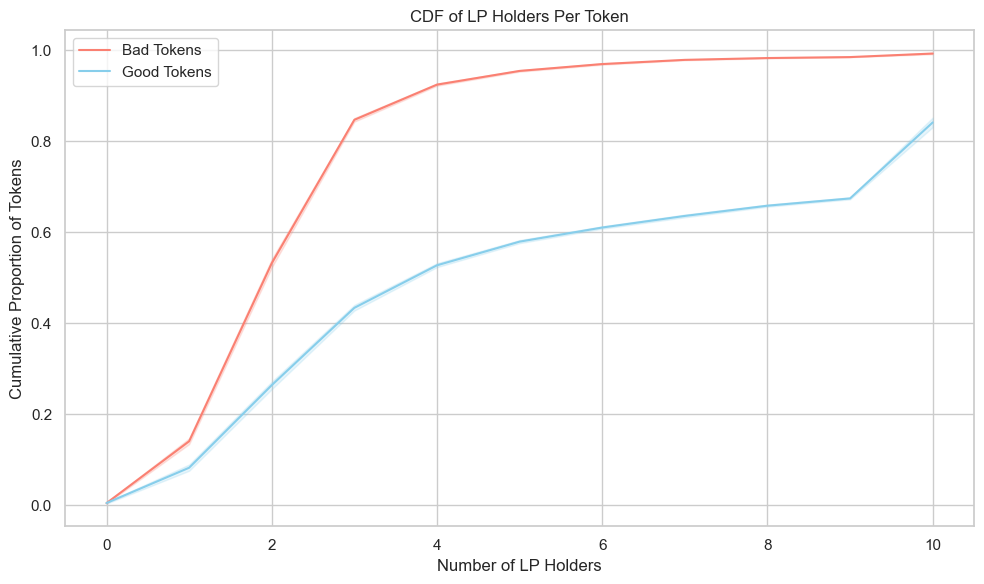

In [20]:
# Load the datasets
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

# Compute unique LP holders per token
def compute_holders_count(df):
    return df.groupby('token_address')['address'].nunique()

holders_bad = compute_holders_count(df_lp_holders_bad)
holders_good = compute_holders_count(df_lp_holders_good)

# Sort the values to build the CDF
sorted_bad = holders_bad.sort_values()
sorted_good = holders_good.sort_values()

# Compute cumulative percentages
cdf_bad = sorted_bad.rank(method='first', pct=True)
cdf_good = sorted_good.rank(method='first', pct=True)

# Plot CDFs
plt.figure(figsize=(10, 6))
sns.lineplot(x=sorted_bad.values, y=cdf_bad.values, label='Bad Tokens', color='salmon')
sns.lineplot(x=sorted_good.values, y=cdf_good.values, label='Good Tokens', color='skyblue')

plt.title('CDF of LP Holders Per Token')
plt.xlabel('Number of LP Holders')
plt.ylabel('Cumulative Proportion of Tokens')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


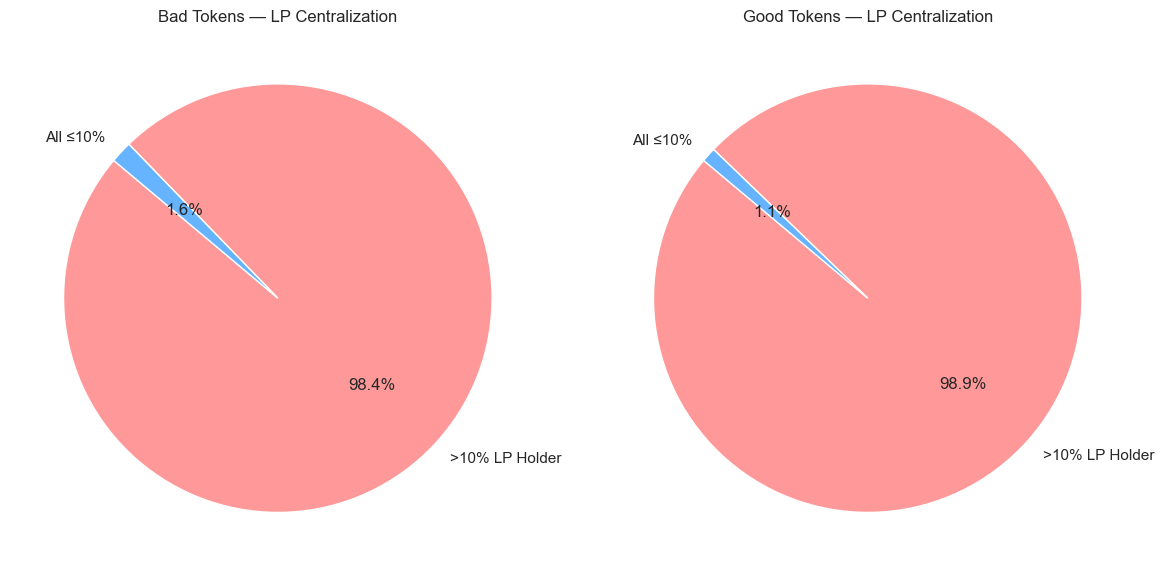

In [21]:
# Load the data
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

def get_lp_ownership_distribution(df):
    # Filter tokens where any LP holder owns more than 10%
    tokens_with_large_lp = df[df['percent'] > 10]['token_address'].nunique()
    total_tokens = df['token_address'].nunique()
    return tokens_with_large_lp, total_tokens - tokens_with_large_lp

# Get data
bad_top, bad_rest = get_lp_ownership_distribution(df_lp_holders_bad)
good_top, good_rest = get_lp_ownership_distribution(df_lp_holders_good)

# Pie chart data
labels = ['>10% LP Holder', 'All ≤10%']
colors = ['#ff9999','#66b3ff']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bad tokens pie
axes[0].pie([bad_top, bad_rest], labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title('Bad Tokens — LP Centralization')

# Good tokens pie
axes[1].pie([good_top, good_rest], labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Good Tokens — LP Centralization')

plt.tight_layout()
plt.show()



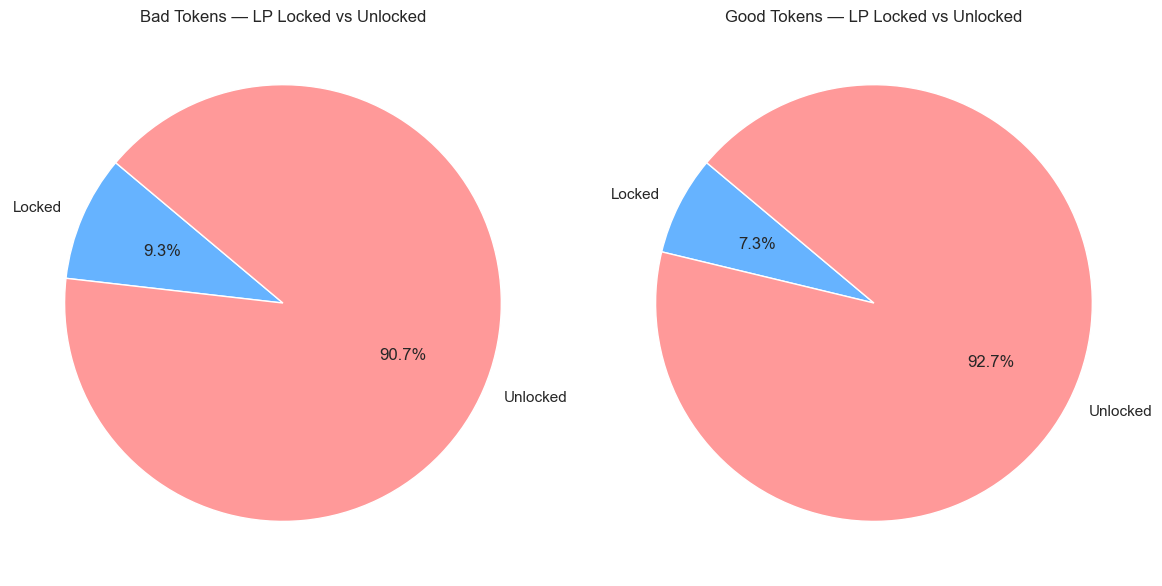

In [22]:
# Load data
df_lp_holders_bad = pd.read_csv("../csv_outputs/bad_tokens/master_lp_holders.csv")
df_lp_holders_good = pd.read_csv("../csv_outputs/good_tokens/master_lp_holders.csv")

def prepare_lp_lock_distribution(df):
    # Clean numeric fields
    df['percent'] = pd.to_numeric(df['percent'], errors='coerce')
    df['balance'] = pd.to_numeric(df['balance'], errors='coerce')
    df = df.dropna(subset=['percent'])

    # Filter out 0x000...000 address
    zero_address = '0x0000000000000000000000000000000000000000'
    df = df[df['address'].str.lower() != zero_address]

    # Count locked/unlocked
    lock_counts = df['is_locked'].value_counts()
    
    # Ensure both categories exist
    locked = lock_counts.get(True, 0)
    unlocked = lock_counts.get(False, 0)

    return [locked, unlocked]

# Get data
locked_counts_bad = prepare_lp_lock_distribution(df_lp_holders_bad)
locked_counts_good = prepare_lp_lock_distribution(df_lp_holders_good)

labels = ['Locked', 'Unlocked']
colors = ['#66b3ff', '#ff9999']

# Plot side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bad tokens
axes[0].pie(locked_counts_bad, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Bad Tokens — LP Locked vs Unlocked")

# Good tokens
axes[1].pie(locked_counts_good, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[1].set_title("Good Tokens — LP Locked vs Unlocked")

plt.tight_layout()
plt.show()


In [23]:
import re
# Exclude zero address
df_lp_holders = df_lp_holders[df_lp_holders['address'] != '0x0000000000000000000000000000000000000000']

# Aggregate LP holders per token
agg_lp_holders = df_lp_holders.groupby('token_address').agg({
    'balance': ['mean', 'sum', 'std', 'count'],
    'percent': ['mean', 'sum', 'std', 'max'],
    'is_locked': 'mean'  # ratio of locked holders
})

# Flatten MultiIndex columns
agg_lp_holders.columns = ['_'.join(col) for col in agg_lp_holders.columns]
agg_lp_holders.reset_index(inplace=True)

# Drop categorical and boolean columns
liquidity_numeric = df_liquidity.select_dtypes(include='number').copy()

# Keep token_address for merging
liquidity_numeric['token_address'] = df_liquidity['token_address']

# Merge on token_address
merged_df = pd.merge(liquidity_numeric, agg_lp_holders, on='token_address', how='inner')

# Drop rows with NaNs (optional)
merged_df = merged_df.dropna()

# Helper to strip variable suffixes
def base_var_name(var):
    return re.sub(r'_(cleaned|clipped|mean|sum|std|max|count)$', '', var)

# Separate variable lists
lp_cols = [col for col in merged_df.columns if any(stat in col for stat in ['balance_', 'percent_', 'is_locked'])]
liq_cols = [col for col in liquidity_numeric.columns if col != 'token_address']

# Initialize R² matrix
r2_df = pd.DataFrame(index=lp_cols, columns=liq_cols)

# Compute R², skipping variables with matching base names
for y_col in lp_cols:
    for x_col in liq_cols:
        if base_var_name(x_col) == base_var_name(y_col):
            r2_df.loc[y_col, x_col] = np.nan
            continue
        X = merged_df[[x_col]]
        y = merged_df[y_col]
        if len(X) > 2:
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)
            r2_df.loc[y_col, x_col] = r2

# Convert to float
r2_df = r2_df.astype(float)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(r2_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, mask=r2_df.isnull())
plt.title("R² Scores: LP Holder Aggregates vs Liquidity Variables (Excluding Self-like Comparisons)")
plt.xlabel("Liquidity Variables")
plt.ylabel("LP Holder Aggregates")
plt.tight_layout()
plt.show()


NameError: name 'df_lp_holders' is not defined